In [1]:
from itertools import permutations as perms
from itertools import product
import numpy as np
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# load s2 mat
# find k_star mat
# for each mu1, mu2, calc free eenergy at kstar, find min phase, store in array
# visulaize stores

# PABUS

In [4]:
from unbound_poly_vertex import *

In [5]:
# # ID = 9987.64006
# ID = 9995.64006
# # ID = 9997.64006
# ID = 1000.04
ID = 12346.04

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

# [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
[n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [6]:
rho_p

3.0100000000000006e-09

In [7]:
# %%time
# K STAR stab anal NUMBER DENSITY THEORY

chi = 0

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:]))) 

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):

            S2_mat =  s2_mats[i][j][ik].copy()

            
            # FULL SOLUTION, 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                # S2_inv = np.linalg.inv(S2_mat)

                S2_inv = np.linalg.inv(S2_mat)
            
                # poly/solv reduction
                S2_inv_ps =  np.array([[S2_inv[0,0] + S2_inv[4,4], S2_inv[0,1], S2_inv[0, 2], S2_inv[0, 3]],\
                   [S2_inv[1,0], S2_inv[1,1] , S2_inv[1,2], S2_inv[1,3]],\
                   [S2_inv[2,0], S2_inv[2,1] , S2_inv[2,2], S2_inv[2,3]],\
                   [S2_inv[3, 0], S2_inv[3, 1], S2_inv[3, 2], S2_inv[3,3]]])
                
                # then apply unbound poly reduction
                T = np.array([[1,0,0], [0,1,0], [0,0,1], [1,-1,-1]]) # \Delta_{unred} = T \Delta_{red}
            
                S2_inv_full = np.einsum("ij, ik, jl -> kl", S2_inv_ps, T, T) # only in terms of P, A, B
            
                G2 = np.array([[S2_inv_full[0,0] - 2*chi, S2_inv_full[0,1], S2_inv_full[0, 2]],\
                   [S2_inv_full[1,0], S2_inv_full[1,1] + v_int[0,0]*Vol_int, S2_inv_full[1,2] + v_int[0,1]*Vol_int],\
                   [S2_inv_full[2,0], S2_inv_full[2,1] + v_int[1,0]*Vol_int, S2_inv_full[2,2] + v_int[1,1]*Vol_int]])
                                    
#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL (no int vol)

                # #CORRECT (using interaction volume term)
                # G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                #    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                #    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])

#                 # testing chi_12
#                 chi_12 = 100#v_int[1,0] - ( (v_int[0,0] + v_int[1,1])/2 )
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + 0*Vol_int, S2_inv[2,3] + chi_12*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + chi_12*Vol_int, S2_inv[3,3] + 0*Vol_int]])
            
# #                 testing v_c
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + -2*Vol_int, S2_inv[2,3] + 2*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + 2*Vol_int, S2_inv[3,3] + -2*Vol_int]])
                
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

#             ########################### POLY/SOLV only
#             S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

# #             if phi_c >= 0.999:
# #                 raise Exception("melt!")
#             S2_det = np.linalg.det(S2_mat)           
            
#             if S2_det != 0:# and S2_cond < 1e10:
#                 S2_inv = np.linalg.inv(S2_mat)

# #                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
#                 G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

#                 val = G2[0]
# #                 min_val = np.min(val)            
#                 min_eigval_arr_ps[i][j][ik] = val
#             ########################### POLY/SOLV only


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             print(minval_allk)
            min_eigval_arr_allk_DENS[i][j] = minval_allk

            if len(min_vecs[np.where(min_vals==minval_allk)]) > 1: # eigenval minimized at multiple ks
                min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)][0]#[0][0] #double zero if saving as objects
            else:
                min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

            if len(k_vec[np.where(min_vals==minval_allk)]) > 1:
                k_star = k_vec[np.where(min_vals==minval_allk)][0] # corresponding k 
            else:
                k_star = k_vec[np.where(min_vals==minval_allk)]
#             print(k_star)
            k_star_arr_DENS[i][j] = k_star

            
#         min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
# #         if len(min_vals_ps) != 0:
# #             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [8]:
k_vec[0]

0.0031622776601683794

In [ ]:
# chi = 0
phases = np.zeros((len(mu1_array[:]), len(mu2_array[:]))) - 1 
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
        if i != 3:
            continue
        if j != 3:
            continue
        print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        # q_star = k_vec[10]#k_star_arr_DENS[i,j]
        # q_star = 0.021261123338996556
        if q_star == -1:
            print("OUT OF SPIN- no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
            raise Exception("NOOOO")
        elif q_star == k_vec[0]:
            print("MACROPHASE SEP")
            phases[i,j] = 1 # macrophase sep
            raise Exception("NOOOO")

        # else: #microphse sep
        
        # print(q_star)
        s_bnd_A = s_bind_A_arr[i,j,:]
        s_bnd_B = s_bind_B_arr[i,j,:]
        # FA = calc_fa(s_bnd_A, s_bnd_B)
        # chrom[11] = [FA, 1-FA]
        
        lam_q = q_star*np.array([1, 0, 0])

        cyl_q1 = q_star*np.array([1, 0, 0])
        cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
        cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
        cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
        
        bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
        bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
        bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
        bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
        bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
        bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
        
        
        lam_g3 = 0
        # G3 = gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs) # all g3s are eqivlaent
        # cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
        # bcc_g3 = (4/(3*np.sqrt(6))) * G3
        
        # print(chrom[11])
        G4_00 = gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))
        lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
        
        # print("test g4 mag impact")
        # # lam_g4 /= 1e40
        # lam_g4 /= 1e30
        
        # cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
        #   72*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])) )
        
        # bcc_g4 = (1/24)* (G4_00 \
        #          + 8*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
        #          + 2*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
        #          + 4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )

        # print("simplified test bcc")
        # bcc_g4 = (1/24)* (4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
        
        lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)
        cyl_g2 = lam_g2
        bcc_g2 = lam_g2
        

        initial = [0, 0, 0] # poly, A, B
        # print("SWITCHED signs")
        amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)
        
        # lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                        # +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

        
        lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                        +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))
        # print(lamF)

            
        amps_l_no4 = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)
        
        lamF_no4 = np.real(np.einsum("ij,i,j ->", lam_g2, amps_l_no4, amps_l_no4))
        
        # print("lam_F: ", lamF)
        # print("lamF_no4: ", lamF_no4)
        
        # amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps, amps, amps, amps)), initial, disp=False)
        
        # cylF = np.real(np.einsum("ij,i,j ->", cyl_g2, amps_cy, amps_cy) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps_cy, amps_cy, amps_cy) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps_cy, amps_cy, amps_cy, amps_cy))

        # amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps, amps, amps, amps)), initial, disp=False)
        
        # bccF = np.real(np.einsum("ij,i,j ->", bcc_g2, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps_bcc, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps_bcc, amps_bcc, amps_bcc, amps_bcc))

        # minF = np.min([lamF, cylF, bccF, 0])
        print("energies:")
        print([lamF])
        # print([lamF, cylF, bccF])
        # if minF == 0:
        #     raise Exception("phase sep not stable in spinodla??")
        # elif minF == lamF:
        #     phases[i,j] = 2
        # elif minF == cylF:
        #     phases[i,j] = 3
        # elif minF == bccF:
        #     phases[i,j] = 4

        # amp_l1, amp_l2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * lam_g2 + amps[0]**3 * lam_g3 + amps[0]**4 * lam_g4 + \
        #                                                 amps[1]**2 * lam_g2_2 + amps[1]**3 * lam_g3_2 + amps[1]**4 * lam_g4_2 + \
        #                                                 amps[0]**2 * amps[1] * lam_g3_mix + amps[0]**2 * amps[1]**2 * lam_g4_mix), \
        #                       initial, disp=False)   

mu:  -3.5 -3.5


<Figure size 640x480 with 0 Axes>

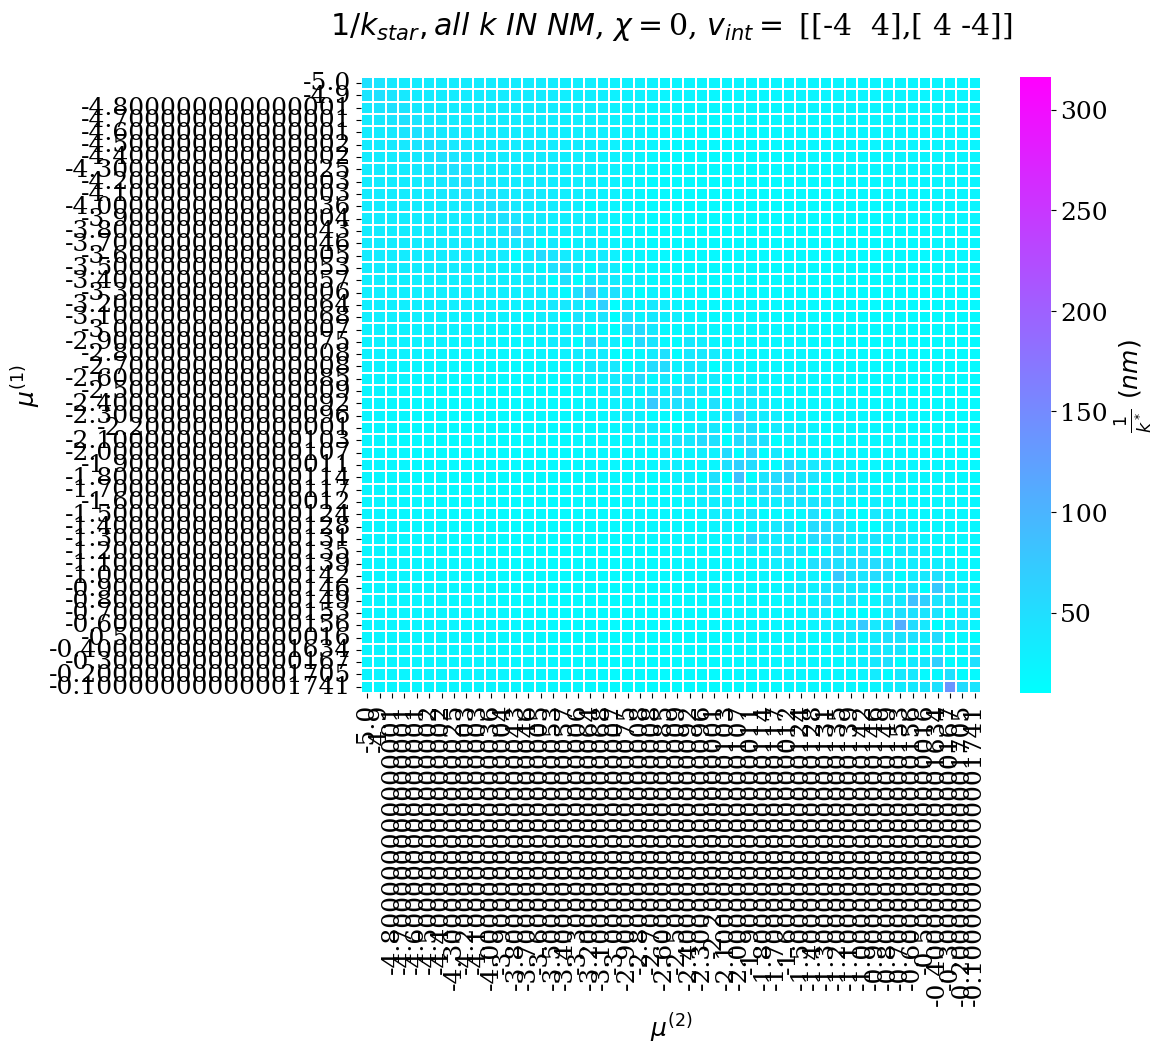

In [11]:
# Explanation: first choose distances. These distances must be in the same units at the persisitnece length due  to exp(xm) term
# in sf calculation. Doesnt matter if used b to scale the lengths used- they are still in nanometers
# then invert these distances to get magnitudes of wavevectors
# then find k star, and invert it to get the critical lengthscale in units of nm


fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = len(mu1_array)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap((1/(k_star_arr_DENS[min_ind:max_ind,min_ind:max_ind])), linewidth=0.25, cmap = "cool", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"},\
                    vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})

# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

ax.axvline(x=50.5, linewidth=4, color="black", linestyle = "--")
ax.axhline(y=50.5, linewidth=4, color="black", linestyle = "--")

# plt.plot(35.75,10.5,'ro') 
# plt.plot(27.3,10.5,'go') 

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 1/k_{star}, all \ k \ IN \ NM$" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


# clean sf scaling

In [10]:
# from final_binder_diblock_vertex import *
# from PABS_correct_reduc import *


In [12]:
# define chrom object
# select a mu1, mu2 in micro phase region
# calc free E, using binding states from ID = 10001.04006
# see if F_lam changes when change alpha (rho_p, v_s, v_m)

In [14]:
# mu_max = 0#0.1 #10
# mu_min = -5#-9
# del_mu = .5 #0.25

# # mu_max = 10
# # mu_min = -10
# # del_mu = 10 #0.25

# klog_min = -2.5
# klog_max = -1
# klog_num = 30


# n_bind = 2 #types of proteins/marks


# chi = None

# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT


# v_int =  np.array([[-4, 4], [4, -4]])

# M = 50
# print("coarse grained or real???")


# # rho_c = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3
# avo = 6.02e23 # num / mol
# dens_p = 1 # g/cm^3
# mol_weight_p = 1e5 # g/mol

# rho_p = (avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3  ) #/ 1e8
# factor = 1e8 
# rho_p = rho_p / factor


# avo = 6.02e23
# water_molmas = 18
# rho_s = np.nan# calculated for by alpha #avo * (1/water_molmas) * (1000  *(1000/1) * (1/1e9)**3)#  num / nm^3, pure water

# chrom_type = "diblock"

# nm = M
# pa_vec = np.arange(0, nm, 1) / (nm-1)
# pb_vec = 1-pa_vec

# poly_marks = [pa_vec, pb_vec]

# vs = .25**3 # nm^3
# vm = 1**3 # nm^3 
# chrom = def_chrom(n_bind, v_int, e_m, rho_p, rho_s, poly_marks, mu_max, mu_min, del_mu, vs, vm, chrom_type)

# [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

# k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)

In [13]:
# # ID = 9987.64006
# ID = 9995.64006
# # ID = 9997.64006
ID = 1000.04
# ID = 12345.941

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

# [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
[n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [15]:
rho_p

3.0100000000000006e-09

In [20]:
# avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3

In [22]:
# mu1_array = np.arange(mu_min, mu_max, del_mu)
# mu2_array = np.arange(mu_min, mu_max, del_mu)

# ID = 10001.04006

# s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
# s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
# spacing = int(1 / del_mu)

In [10]:
# %%time
# K STAR stab anal NUMBER DENSITY THEORY

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
# chi = -1.0
chi = 0

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:]))) 


# avo = 6.02e23 # num poly / mol
# dens_p = 1 # g/cm^3 -> less for polymer solution
# mol_weight_p = 1e5 # g/mol

# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
# n_p = 1e8 
# A = 1/(b) # nm^2 cross sectional area
# vol_nuc = A*(b) # volume of nucleosome


# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 * 10
# n_p = N**2 #

# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
# n_p = 1e8#N_m**2 # from converting volume fraction sf to number density sf 

# vol_solv = 1#N #1#10000000**3# (4e-10)**3

# s2_mats = s2_mat_shlk_dens
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()

            
            # EDIT  2. goal is 1/V * (N**2 * 1/N**2) = rho_c / (M * np)
            # in code sfs defined as S =N**2 * 1/N**2 ~integral~. 
            # then in sf_mats multiply facotr of rho_c / N^2. overall prefacotr is rho_c/N^2
            # To get to goal, must multiply by (N_m^2 * M)/np
            # S2_mat *= (N_m**2 * M)/n_p
            # S2_mat[1][1] /= (N_m**2 * M)/n_p
            # print(S2_mat)

            
            
# #            # TESTING DIF MAGNITUDES OF RHO_S
#             rho_s_test = rho_s * 10000# 1e-5#33#1e5
#             S2_mat[1][1] = rho_s_test 
            
#             # if phi_c >= 0.999:
#             #     raise Exception("melt!")

#            # TESTING DIF MAGNITUDES of RHO_P
            # #print("CHANGED RHO_C!!!!!!!")
            # rho_c_test = rho_c / 10000
            # rho_c_test = rho_p
            # S2_mat /= rho_c
            # S2_mat *= rho_c_test
            # S2_mat[1][1] *= (rho_c/rho_c_test)



            
            # FULL SOLUTION, 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
            # print("S2 det: ", S2_det)
            # print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL (no int vol)

                #CORRECT (using interaction volume term)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])

#                 # testing chi_12
#                 chi_12 = 100#v_int[1,0] - ( (v_int[0,0] + v_int[1,1])/2 )
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + 0*Vol_int, S2_inv[2,3] + chi_12*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + chi_12*Vol_int, S2_inv[3,3] + 0*Vol_int]])
            
# #                 testing v_c
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + -2*Vol_int, S2_inv[2,3] + 2*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + 2*Vol_int, S2_inv[3,3] + -2*Vol_int]])
                
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

#             ########################### POLY/SOLV only
#             S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

# #             if phi_c >= 0.999:
# #                 raise Exception("melt!")
#             S2_det = np.linalg.det(S2_mat)           
            
#             if S2_det != 0:# and S2_cond < 1e10:
#                 S2_inv = np.linalg.inv(S2_mat)

# #                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
#                 G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

#                 val = G2[0]
# #                 min_val = np.min(val)            
#                 min_eigval_arr_ps[i][j][ik] = val
#             ########################### POLY/SOLV only


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             print(minval_allk)
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             print(k_star)
            k_star_arr_DENS[i][j] = k_star

            
#         min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
# #         if len(min_vals_ps) != 0:
# #             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [11]:
k_star_arr_DENS[3,3]

0.021261123338996556

In [36]:
i = 7
j = 7
s_bnd_A = s_bind_A_arr[i,j,:]
s_bnd_B = s_bind_B_arr[i,j,:]
q_star = k_star_arr_DENS[i,j]
lam_q = q_star*np.array([1, 0, 0])

Ks = np.array([lam_q, -lam_q, lam_q, -lam_q])
K1, K2, K3, K4 = Ks
# def gamma4(chrom, s_bnd_A, s_bnd_B, Ks):
#     K1, K2, K3, K4 = Ks
#     if np.linalg.norm(K1+K2+K3+K4) >= 1e-10:
#         raise Exception('Qs must add up to zero')    
    # K = np.linalg.norm(K1)
    # K12 = np.linalg.norm(K1+K2)
    # K13 = np.linalg.norm(K1+K3)
    # K14 = np.linalg.norm(K1+K4)

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom
    
M4 = calc_mon_mat_4(s_bnd_A, s_bnd_B)
    
s4 = ( rho_c/(M) ) * calc_sf4(chrom, M4, [K1], [K2], [K3]) 
s4

array([[[[7.81864616e+07, 3.80366404e+07, 3.80366404e+07,
          0.00000000e+00],
         [3.80366404e+07, 2.24621905e+07, 1.45503724e+07,
          0.00000000e+00],
         [3.80366404e+07, 1.45503724e+07, 2.24621905e+07,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00]],

        [[3.80366404e+07, 1.56602288e+07, 2.13459654e+07,
          0.00000000e+00],
         [2.24621905e+07, 1.14487970e+07, 1.03871114e+07,
          0.00000000e+00],
         [1.45503724e+07, 3.79069538e+06, 1.03871114e+07,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00]],

        [[3.80366404e+07, 2.13459654e+07, 1.56602288e+07,
          0.00000000e+00],
         [1.45503724e+07, 1.03871114e+07, 3.79069538e+06,
          0.00000000e+00],
         [2.24621905e+07, 1.03871114e+07, 1.14487970e+07,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [38]:
M3 = calc_mon_mat_3(s_bnd_A, s_bnd_B)
    
s3 = ( rho_c/(M) ) * calc_sf3(chrom, M3, [K1], [K2]) 
s3

array([[[2959.17998072, 1440.63991239, 1440.63991239,    0.        ],
        [1438.15797518,  700.14929571,  700.14929571,    0.        ],
        [1438.15797518,  700.14929571,  700.14929571,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ]],

       [[1438.15797518,  700.14929571,  700.14929571,    0.        ],
        [1016.01967611,  494.6365232 ,  494.6365232 ,    0.        ],
        [ 382.14095022,  186.04056145,  186.04056145,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ]],

       [[1438.15797518,  700.14929571,  700.14929571,    0.        ],
        [ 382.14095022,  186.04056145,  186.04056145,    0.        ],
        [1016.01967611,  494.6365232 ,  494.6365232 ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ]],

       [[   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.

In [13]:
1 - s_bnd_A + s_bnd_B

array([8.31439452e-02, 9.07483508e-03, 2.64325194e-03, 2.01263117e-03,
       1.95874307e-03, 1.98484435e-03, 2.03588988e-03, 2.11598894e-03,
       2.25741950e-03, 2.53671288e-03, 3.11413052e-03, 4.30128311e-03,
       6.66351950e-03, 1.11573667e-02, 1.92889047e-02, 3.32572253e-02,
       5.60231981e-02, 9.12282810e-02, 1.42894901e-01, 2.14879919e-01,
       3.10125634e-01, 4.29841348e-01, 5.72819817e-01, 7.35109978e-01,
       9.10207303e-01, 1.08979270e+00, 1.26489002e+00, 1.42718018e+00,
       1.57015865e+00, 1.68987437e+00, 1.78512008e+00, 1.85710510e+00,
       1.90877172e+00, 1.94397680e+00, 1.96674277e+00, 1.98071110e+00,
       1.98884263e+00, 1.99333648e+00, 1.99569872e+00, 1.99688587e+00,
       1.99746329e+00, 1.99774258e+00, 1.99788401e+00, 1.99796411e+00,
       1.99801516e+00, 1.99804126e+00, 1.99798737e+00, 1.99735675e+00,
       1.99092516e+00, 1.91685605e+00])

In [14]:
# chi = 0
phases = np.zeros((len(mu1_array[:]), len(mu2_array[:]))) - 1 
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
        if i != 3:
            continue
        if j != 3:
            continue
        print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        # q_star = k_vec[10]#k_star_arr_DENS[i,j]
        # q_star = 0.021261123338996556
        if q_star == -1:
            print("OUT OF SPIN- no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
            raise Exception("NOOOO")
        elif q_star == k_vec[0]:
            print("MACROPHASE SEP")
            phases[i,j] = 1 # macrophase sep
            raise Exception("NOOOO")

        # else: #microphse sep
        
        # print(q_star)
        s_bnd_A = s_bind_A_arr[i,j,:]
        s_bnd_B = s_bind_B_arr[i,j,:]
        # FA = calc_fa(s_bnd_A, s_bnd_B)
        # chrom[11] = [FA, 1-FA]
        
        lam_q = q_star*np.array([1, 0, 0])

        cyl_q1 = q_star*np.array([1, 0, 0])
        cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
        cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
        cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
        
        bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
        bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
        bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
        bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
        bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
        bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
        
        
        lam_g3 = 0
        G3 = gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs) # all g3s are eqivlaent
        cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
        bcc_g3 = (4/(3*np.sqrt(6))) * G3
        
        # print(chrom[11])
        G4_00 = gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))
        lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
        
        # print("test g4 mag impact")
        # # lam_g4 /= 1e40
        # lam_g4 /= 1e30
        
        cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
          72*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])) )
        
        bcc_g4 = (1/24)* (G4_00 \
                 + 8*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                 + 2*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                 + 4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )

        # print("simplified test bcc")
        # bcc_g4 = (1/24)* (4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
        
        lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)
        cyl_g2 = lam_g2
        bcc_g2 = lam_g2
        

        initial = [0, 0, 0] # poly, A, B
        # print("SWITCHED signs")
        amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)
        
        # lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                        # +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

        
        lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                        +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))
        # print(lamF)

            
        amps_l_no4 = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)
        
        lamF_no4 = np.real(np.einsum("ij,i,j ->", lam_g2, amps_l_no4, amps_l_no4))
        
        # print("lam_F: ", lamF)
        # print("lamF_no4: ", lamF_no4)
        
        amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps, amps, amps, amps)), initial, disp=False)
        
        cylF = np.real(np.einsum("ij,i,j ->", cyl_g2, amps_cy, amps_cy) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3, amps_cy, amps_cy, amps_cy) \
                                            + np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps_cy, amps_cy, amps_cy, amps_cy))

        amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps, amps, amps, amps)), initial, disp=False)
        
        bccF = np.real(np.einsum("ij,i,j ->", bcc_g2, amps_bcc, amps_bcc) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3, amps_bcc, amps_bcc, amps_bcc) \
                                            + np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps_bcc, amps_bcc, amps_bcc, amps_bcc))

        minF = np.min([lamF, cylF, bccF, 0])
        print("energies:")
        print([lamF, cylF, bccF])
        # if minF == 0:
        #     raise Exception("phase sep not stable in spinodla??")
        # elif minF == lamF:
        #     phases[i,j] = 2
        # elif minF == cylF:
        #     phases[i,j] = 3
        # elif minF == bccF:
        #     phases[i,j] = 4

        # amp_l1, amp_l2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * lam_g2 + amps[0]**3 * lam_g3 + amps[0]**4 * lam_g4 + \
        #                                                 amps[1]**2 * lam_g2_2 + amps[1]**3 * lam_g3_2 + amps[1]**4 * lam_g4_2 + \
        #                                                 amps[0]**2 * amps[1] * lam_g3_mix + amps[0]**2 * amps[1]**2 * lam_g4_mix), \
        #                       initial, disp=False)   

mu:  -3.5 -3.5
energies:
[-3.8391573259974064e+224, -1.2174709925345728e+225, -2.239185163400135e+225]


In [15]:
# sig_inds= [0,1,2]
# for a1, a2, a3 in product(sig_inds, repeat=3):
#     print([a1, a2, a3])

In [16]:
lamF

-3.8391573259974064e+224

In [17]:
lamF_no4

-1.22063433501667e+103

In [34]:
lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)
# lam_g2_no_int = (1/2) * 2 * (1) * gamma2_no_int(chrom, s_bnd_A, s_bnd_B, q_star, chi)

In [ ]:
val, vec = np.linalg.eigh(lam_g2)
val

In [ ]:
val, vec = np.linalg.eigh(lam_g2_no_int)
val

In [ ]:
lamF

In [ ]:
lamF_no4

In [ ]:
amps_l_no4_neg = optimize.fmin(lambda amps: -np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)

-np.real(np.einsum("ij,i,j ->", lam_g2, amps_l_no4_neg, amps_l_no4_neg))

In [ ]:
amps_l_no4_neg

In [26]:
amps_l_no4 = optimize.fmin(lambda amps:np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)

np.real(np.einsum("ij,i,j ->", lam_g2, amps_l_no4, amps_l_no4))

-1.2206343350166709e+103

In [28]:
amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)


np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                + np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

-3.8843291424045175e+224

In [216]:
val, vec = np.linalg.eigh(lam_g2)
val

array([-7.73470202e+02,  1.34759369e+01,  1.36219114e+04])

In [218]:
val, vec = np.linalg.eigh(-lam_g2)
val

array([-1.36219114e+04, -1.34759369e+01,  7.73470202e+02])

In [280]:
#neg g2
amps_l_no4_te = optimize.fmin(lambda amps:np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)

np.real(np.einsum("ij,i,j ->", lam_g2, amps_l_no4_te, amps_l_no4_te))

-1.2206343350166709e+103

In [88]:
test = [0, 10000000000000, -10000000000000]
np.real(np.einsum("ij,i,j ->", lam_g2, test, test))

-1.6517984850796e+29

In [184]:
amps_l = [-0.0000000000003,0.0000000000000008,-0.0000000000002]
# amps_l = [-300000,0.0000000008,-20000]
-np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                + np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

1.2865372048288609e-23

In [89]:
np.real( np.einsum("ij,i,j ->", lam_g2, test, test) \
                                +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

-1.6517984850796e+29

In [206]:
amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)

# lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                # +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))


np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))

-3.8843291424045175e+224

In [24]:
f_A = 0.3
f_B = 1- f_A
alpha = .574
s2_q0 = np.array([[1+alpha, f_A, f_B],
                 [f_A, f_A**2, f_A*f_B],
                 [f_B, f_A*f_B, f_B**2]])
np.linalg.det(s2_q0)

-2.663213487098916e-18

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$phase$"})
plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"phases" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()

# old sf scaling calcs

In [3]:
from binder_diblock_vertex_competitive import *
from binder_diblock_gamma234_vertex import *

In [5]:
# # ID = 9987.64006
# ID = 9995.64006
# # ID = 9997.64006
ID = 10001.04006

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [7]:
e_m

array([1.52, 1.52])

In [9]:

avo = 6.02e23 # num poly / mol
dens_p = 1 # g/cm^3 -> less for polymer solution
mol_weight_p = 1e5 # g/mol

rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
rho_p

0.30100000000000005

In [11]:
mu1_array[7]

-1.5

In [13]:
%%time
# K STAR stab anal NUMBER DENSITY THEORY

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
# chi = -1.0
chi = 0

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:]))) 


avo = 6.02e23 # num poly / mol
dens_p = 1 # g/cm^3 -> less for polymer solution
mol_weight_p = 1e5 # g/mol

# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
# n_p = 1e8 
# A = 1/(b) # nm^2 cross sectional area
# vol_nuc = A*(b) # volume of nucleosome


# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 * 10
# n_p = N**2 #

rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
n_p = 1e8#N_m**2 # from converting volume fraction sf to number density sf 

# vol_solv = 1#N #1#10000000**3# (4e-10)**3

# s2_mats = s2_mat_shlk_dens
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()

            
            # EDIT  2. goal is 1/V * (N**2 * 1/N**2) = rho_c / (M * np)
            # in code sfs defined as S =N**2 * 1/N**2 ~integral~. 
            # then in sf_mats multiply facotr of rho_c / N^2. overall prefacotr is rho_c/N^2
            # To get to goal, must multiply by (N_m^2 * M)/np
            S2_mat *= (N_m**2 * M)/n_p
            S2_mat[1][1] /= (N_m**2 * M)/n_p
            # print(S2_mat)

            
            
# #            # TESTING DIF MAGNITUDES OF RHO_S
#             rho_s_test = rho_s * 10000# 1e-5#33#1e5
#             S2_mat[1][1] = rho_s_test 
            
#             # if phi_c >= 0.999:
#             #     raise Exception("melt!")

#            # TESTING DIF MAGNITUDES of RHO_P
            # #print("CHANGED RHO_C!!!!!!!")
            # rho_c_test = rho_c / 10000
            rho_c_test = rho_p
            S2_mat /= rho_c
            S2_mat *= rho_c_test
            S2_mat[1][1] *= (rho_c/rho_c_test)



            
            # FULL SOLUTION, 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
            # print("S2 det: ", S2_det)
            # print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL (no int vol)

                #CORRECT (using interaction volume term)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])

#                 # testing chi_12
#                 chi_12 = 100#v_int[1,0] - ( (v_int[0,0] + v_int[1,1])/2 )
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + 0*Vol_int, S2_inv[2,3] + chi_12*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + chi_12*Vol_int, S2_inv[3,3] + 0*Vol_int]])
            
# #                 testing v_c
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + -2*Vol_int, S2_inv[2,3] + 2*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + 2*Vol_int, S2_inv[3,3] + -2*Vol_int]])
                
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

#             if phi_c >= 0.999:
#                 raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             print(minval_allk)
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             print(k_star)
            k_star_arr_DENS[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

CPU times: total: 125 ms
Wall time: 407 ms


In [15]:
%%time
phases = np.zeros((len(mu1_array[:]), len(mu2_array[:]))) - 1 
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
        if i != 7:
            continue
        if j != 7:
            continue
        # if i != 7:
        #     continue
        # if j != 7:
        #     continue
        print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        print("q_star: ", q_star)
        if q_star == -1:
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
            phases[i,j] = 1 # macrophase sep
        else: #microphse sep
            # print(q_star)
            s_bnd_A = s_bind_A_arr[i,j,:]
            s_bnd_B = s_bind_B_arr[i,j,:]
            FA = calc_fa(s_bnd_A, s_bnd_B)
            chrom[11] = [FA, 1-FA]
            
            lam_q = q_star*np.array([1, 0, 0])

            cyl_q1 = q_star*np.array([1, 0, 0])
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            # G3 = gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs) # all g3s are eqivlaent
            # cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            # bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            
            G4_00 = gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            # print("test g4 mag impact")
            # # lam_g4 /= 1e40
            # lam_g4 /= 1e30
            
            # cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
            #   72*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])) )
            
            # bcc_g4 = (1/24)* (G4_00 \
            #          + 8*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
            #          + 2*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
            #          + 4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )

            # print("simplified test bcc")
            # bcc_g4 = (1/24)* (4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
            
            lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2
            print("lam_g2: ", lam_g2)

            initial = [0, 0, 0] # poly, A, B
            
            amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                               +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)
            
            lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                            +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))
            print(lamF)


            amps_l_no4 = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps)), initial, disp=False)
                                               # +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)
            
            lamF_no4 = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l_no4, amps_l_no4))
                                            # +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))
            # print(lamF)
            print(lamF_no4)
            # amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps, amps, amps, amps)), initial, disp=False)
            
            # cylF = np.real(np.einsum("ij,i,j ->", cyl_g2, amps_cy, amps_cy) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps_cy, amps_cy, amps_cy) \
            #                                     + np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps_cy, amps_cy, amps_cy, amps_cy))

            # amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps, amps, amps, amps)), initial, disp=False)
            
            # bccF = np.real(np.einsum("ij,i,j ->", bcc_g2, amps_bcc, amps_bcc) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps_bcc, amps_bcc, amps_bcc) \
            #                                     + np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps_bcc, amps_bcc, amps_bcc, amps_bcc))

            # minF = np.min([lamF, cylF, bccF, 0])

            # if minF == 0:
            #     raise Exception("phase sep not stable in spinodla??")
            # elif minF == lamF:
            #     phases[i,j] = 2
            # elif minF == cylF:
            #     phases[i,j] = 3
            # elif minF == bccF:
            #     phases[i,j] = 4
    
            # amp_l1, amp_l2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * lam_g2 + amps[0]**3 * lam_g3 + amps[0]**4 * lam_g4 + \
            #                                                 amps[1]**2 * lam_g2_2 + amps[1]**3 * lam_g3_2 + amps[1]**4 * lam_g4_2 + \
            #                                                 amps[0]**2 * amps[1] * lam_g3_mix + amps[0]**2 * amps[1]**2 * lam_g4_mix), \
            #                       initial, disp=False)            

mu:  -1.5 -1.5
q_star:  0.021261123338996556
lam_g2:  [[ 86071.18203331 -88533.39991273 -88533.39991273]
 [-88533.39991273  90671.01652411  91496.91576665]
 [-88533.39991273  91496.91576665  90671.01652411]]
-1.6749901513953286e+234
-8.333425226576081e-06
CPU times: total: 14.4 s
Wall time: 42.2 s


In [49]:
lamF

-1.6749901513953286e+234

In [50]:
lamF_no4

-8.333425226576081e-06

In [25]:
lam_g2 #old

array([[ 1.45722804e+04, -1.02449501e+06, -1.02449501e+06],
       [-1.02449501e+06,  7.26552001e+07,  7.15652754e+07],
       [-1.02449501e+06,  7.15652754e+07,  7.26552001e+07]])

In [25]:
amps_l

array([-1.07472013e+50,  4.26242873e+49,  8.17528698e+49])

In [28]:
lamF

-1.576541078036971e+234

In [24]:
amps_bcc_tst = [0.5,0.5,0.5]
np.real(np.einsum("ij,i,j ->", bcc_g2, amps_bcc_tst, amps_bcc_tst) \
                                                + np.einsum("ijk,i,j,k ->", bcc_g3, amps_bcc_tst, amps_bcc_tst, amps_bcc_tst) \
                                                + np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps_bcc_tst, amps_bcc_tst, amps_bcc_tst, amps_bcc_tst))

NameError: name 'bcc_g3' is not defined

In [ ]:
# problem with g4 construction!

<Figure size 640x480 with 0 Axes>

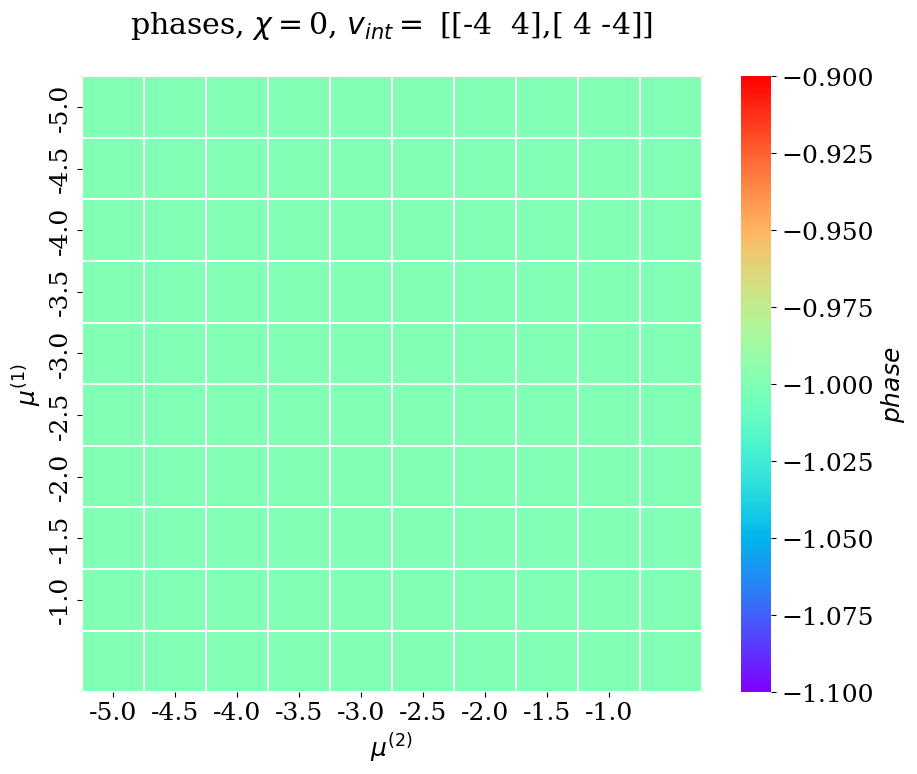

In [26]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$phase$"})
plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"phases" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()

<Figure size 640x480 with 0 Axes>

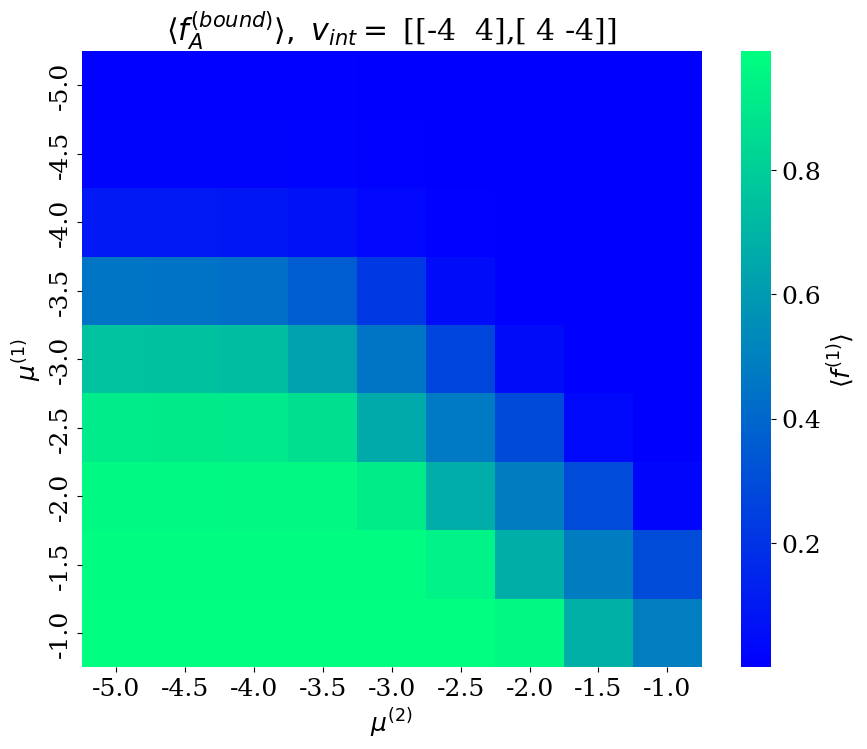

In [28]:
def calc_fa(phia, phib):
    nm = len(phia)
    
    ind = 0
    for i in range(nm):
        if phia[i] > phib[i]:
            ind += 1
    
    fa = ind / nm
    
    return fa

def calc_frac_bound(phia):
    nm = len(phia)
    
    # ind = 0
    # for i in range(nm):
    #     if phia[i] > phib[i]:
    #         ind += 1
    
    return np.sum(phia)/nm
    
def calc_fb(phia, phib):
    nm = len(phia)
    
    ind = 0
    for i in range(nm):
        if phib[i] > phia[i]:
            ind += 1
    
    fb = ind / nm
    
    return fb

# %%time

n_mu = len(mu1_array)
fa_mat = np.zeros((n_mu, n_mu))
a_frac = np.zeros((n_mu, n_mu))
b_frac = np.zeros((n_mu, n_mu))

f_ref = np.min(np.array([v_int[0,0], v_int[1,1], v_int[0,1], e_m[0] / 2,  e_m[1] / 2]))

for i_a in range(n_mu):
    mu_1 = mu1_array[i_a]
    for i_b in range(n_mu):
        mu_2 = mu2_array[i_b]

        # for i in range(nm):
        #     pa_vec[i] = i / (nm - 1)
        
        phia = s_bind_A_arr[i_a, i_b, :]
        phib = s_bind_B_arr[i_a, i_b, :]

        # phib = = eval_phi(pa_vec, mu_1, mu_2, e_m[0], e_m[1], v_int[0,0], v_int[1,1], v_int[0,1], f_ref)
        
        fa_mat[i_a, i_b] = calc_fa(phia, phib)
        a_frac[i_a,i_b] = calc_frac_bound(phia)
        b_frac[i_a,i_b] = calc_frac_bound(phib)

    # print(i_a)

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ind_min = 0
ind_max = -1#50
# f_gam_soln_arr = density_maps

# #protein 1
ax = sns.heatmap(a_frac[ind_min:ind_max, ind_min:ind_max], linewidth=0., cmap = "winter", xticklabels=mu2_array[ind_min:ind_max], yticklabels=mu1_array[ind_min:ind_max], cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
### ax.set_xticks(ax.get_xticks()[::2])
### ax.set_xticklabels(mu2_array[::2].astype(np.int64))
### ax.set_yticks(ax.get_yticks()[::2])
### ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# ax.set_xticks(ax.get_xticks()[:ind_max:spacing])
# ax.set_xticklabels(np.round(mu2_array[ind_min:ind_max:spacing],0).astype(np.int64))
# ax.set_yticks(ax.get_yticks()[:ind_max:spacing])
# ax.set_yticklabels(np.round(mu2_array[ind_min:ind_max:spacing],0).astype(np.int64))


# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=44., linewidth=2, color="red", linestyle = "-") 
# ax.axvline(x=44., linewidth=2, color="red", linestyle = "-")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$ \langle f_{A}^{(bound)} \rangle, $"  \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

plt.show()

<Figure size 640x480 with 0 Axes>

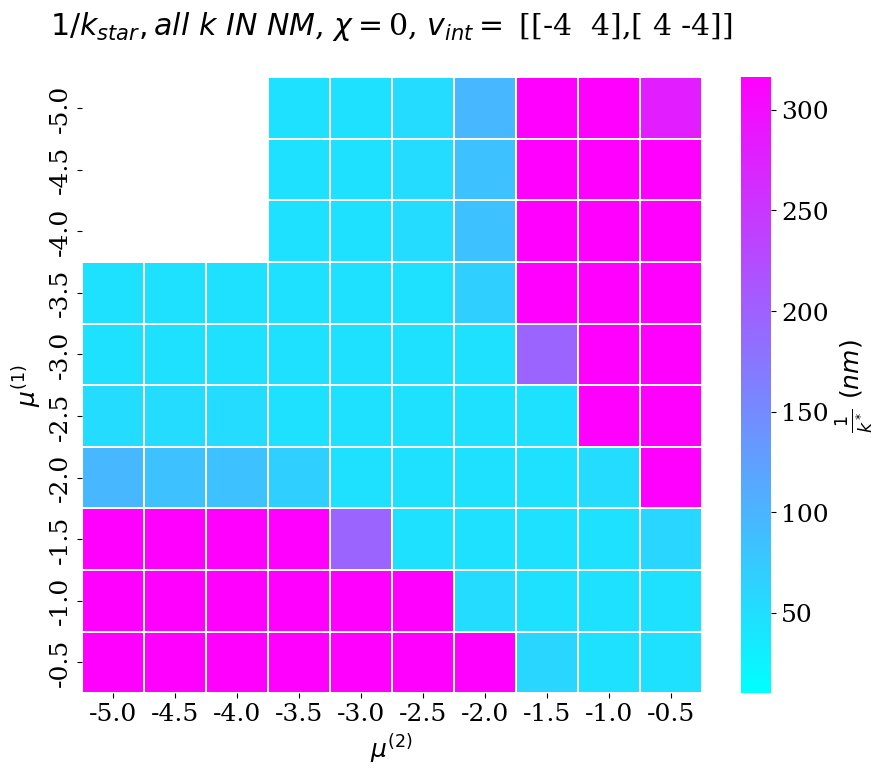

In [21]:
# Explanation: first choose distances. These distances must be in the same units at the persisitnece length due  to exp(xm) term
# in sf calculation. Doesnt matter if used b to scale the lengths used- they are still in nanometers
# then invert these distances to get magnitudes of wavevectors
# then find k star, and invert it to get the critical lengthscale in units of nm


fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = len(mu1_array)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap((1/(k_star_arr_DENS[min_ind:max_ind,min_ind:max_ind])), linewidth=0.25, cmap = "cool", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"},\
                    vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})

# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

ax.axvline(x=50.5, linewidth=4, color="black", linestyle = "--")
ax.axhline(y=50.5, linewidth=4, color="black", linestyle = "--")

# plt.plot(35.75,10.5,'ro') 
# plt.plot(27.3,10.5,'go') 

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 1/k_{star}, all \ k \ IN \ NM$" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

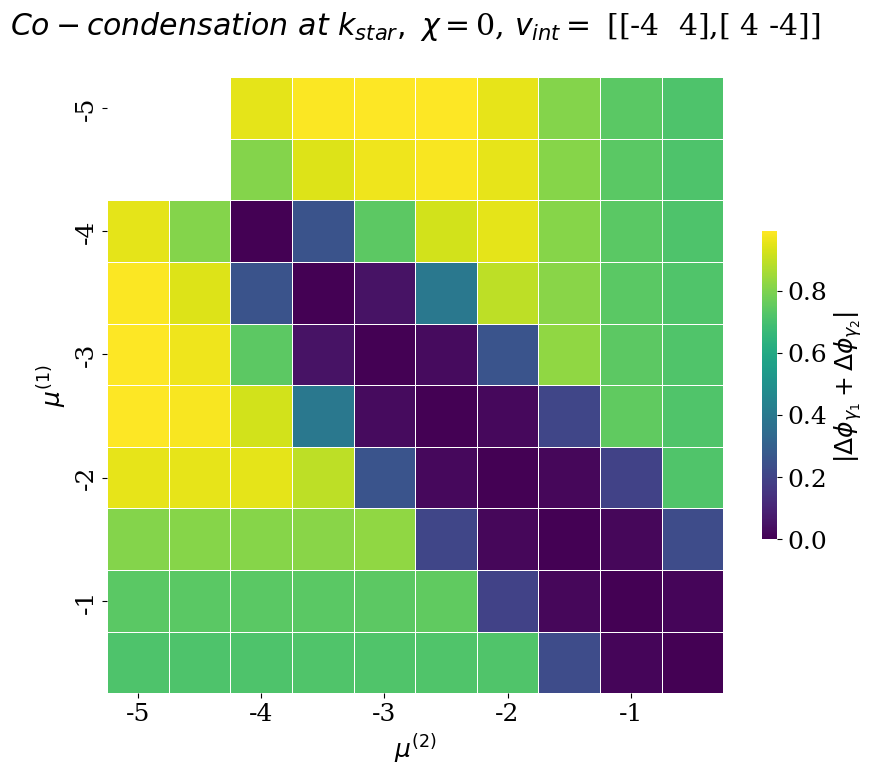

In [44]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

min_ind = 0
max_ind = len(mu1_array)

abs_mat = np.abs(prot1_fluc + prot2_fluc)
binary_map = abs_mat.copy()
binary_map[binary_map > 1] = 2
binary_map[binary_map <= 1] = 0

abs_mat[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan

ax = sns.heatmap(abs_mat[min_ind:max_ind,min_ind:max_ind], square = True, linewidth=0.5, cmap = "viridis", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind], cbar_kws={"shrink": 0.5, 'label':  r"$ |\Delta \phi_{\gamma_1} + \Delta \phi_{\gamma_2}|$ "})
#     ax = sns.heatmap(binary_map, linewidth=0.5, cmap = cmap, xticklabels=mu2_array, yticklabels=mu1_array)
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([0.5,1.5])
# colorbar.set_ticklabels([r"$ | \Delta \phi_{\gamma_1} $ + $ \Delta \phi_{\gamma_2} | \leq 1$", r"$ | \Delta \phi_{\gamma_1} $ + $ \Delta \phi_{\gamma_2} | > 1$"])

    
# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
# ax = sns.heatmap(np.abs(prot2_fluc), linewidth=0.25, norm = LogNorm(), cmap = "Blues", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ |\Delta \phi_{\gamma_2}|$ "})
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))



# ax.axvline(x=50, linewidth=4, color="black", linestyle = "--")
# ax.axvline(x=47, linewidth=4, color="black", linestyle = "--")
# ax.axhline(y=50, linewidth=4, color="black", linestyle = "--")
# ax.scatter(50,40)
# ax.scatter(40,30)
# plt.plot(60.5,60.5,'ro') 
# plt.plot(60.5,50.5,'go') 

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$Co-condensation \ at \ k_{star}, $" +  " $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()

<Figure size 640x480 with 0 Axes>

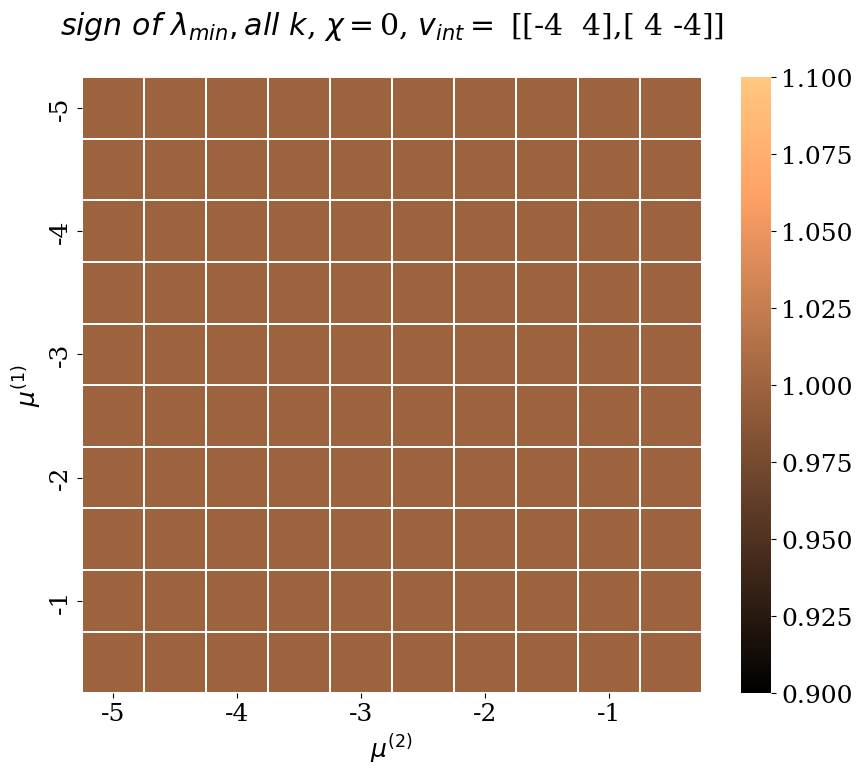

In [31]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
min_ind = 0
max_ind = len(mu1_array)
ax = sns.heatmap(np.sign(min_eigval_arr_allk_DENS[min_ind:max_ind,min_ind:max_ind]), linewidth=0.1, cmap = "copper", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind])
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(mu2_array[min_ind:max_ind:spacing],0).astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="w", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="w", linestyle = "--")

ax.axvline(x=50.5, linewidth=4, color="white", linestyle = "--")
ax.axhline(y=50.5, linewidth=4, color="white", linestyle = "--")

ax.axhline(y=44., linewidth=2, color="red", linestyle = "-") 
ax.axvline(x=44., linewidth=2, color="red", linestyle = "-")

# ax.axhline(y=17.5, linewidth=2, color="blue", linestyle = "-") 
# ax.axvline(x=18.5, linewidth=2, color="blue", linestyle = "-")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
v_int_orig = v_int.copy()
# v_int = [[-2,2],[2,-2]]

# plt.title("$\chi_{12} = %s,$ " % chi_12 + looping + r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
#           str(np.round(chi, 2)) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
#           "\n")

plt.title( r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")
v_int = v_int_orig

plt.show()


In [ ]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)


# min_ind = 0
# max_ind = -1

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# # k_ind = 20
# #     poly_fluc = min_eigvec_arr_allk[:,:,0]
# #     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# #     prot1_fluc = min_eigvec_arr_allk[:,:,1]
# #     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# #     prot2_fluc = min_eigvec_arr_allk[:,:,2]
# #     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# # k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# # ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
# ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
#                  cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"phases" +  ", $\chi = $" + \
#           str(np.round(chi, 2)) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
#           "\n")


# plt.show()

In [ ]:
# %%time
# #SINGLE WAVEMODE PHASE DIAGRAM 
# N = 10000

# # fa_array = np.arange(0.3, 0.501, 0.01)#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(8, 25, .01)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# N_m = 1000
# b = 1
# M = 10

# fa_array = [0.3, 0.4, 0.5, 0.6, 0.7]
# # poly_type = "diblock"
# # n_p = 1


# lam_pnts = np.array([])
# cyl_pnts = np.array([])
# bcc_pnts = np.array([])
# gyr_pnts = np.array([])
# sq_cyl_pnts = np.array([])
# sim_cub_pnts = np.array([])
# fcc_pnts = np.array([])
# dis_pnts = np.array([])

# for FA in fa_array:
#     poly_mat, dens = poly_mat_gen(poly_type, M, n_p, FA) 
    
#     q_star = spinodal_gaus(poly_mat, dens, N_m, b, M)
#     q_star = q_star[0]
    
#     lam_q = q_star*np.array([1, 0, 0])
    
#     cyl_q1 = q_star*np.array([1, 0, 0])
#     cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
#     cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
#     cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
#     bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
#     bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
#     bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
#     bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
#     bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
#     bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
    
#     sq_6 = (1/np.sqrt(6)) * q_star
#     gyr_q1 = sq_6*np.array([-1, 2, 1])
#     gyr_q2 = sq_6*np.array([2, 1, -1])
#     gyr_q3 = sq_6*np.array([1, -1, 2])
#     gyr_q4 = sq_6*np.array([2, -1, -1])
#     gyr_q5 = sq_6*np.array([-1, 2, -1])
#     gyr_q6 = sq_6*np.array([-1, -1, 2])
    
#     gyr_q7 = sq_6*np.array([2, 1, 1])
#     gyr_q8 = sq_6*np.array([1, 2, 1])
#     gyr_q9 = sq_6*np.array([1, 1, 2])
#     gyr_q10 = sq_6*np.array([2, -1, 1])
#     gyr_q11 = sq_6*np.array([1, 2, -1])
#     gyr_q12 = sq_6*np.array([-1, 1, 2])

#     sq_cyl_q1 = q_star * np.array([1,0,0])
#     sq_cyl_q2 = q_star * np.array([0,1,0])
    
#     sim_cub_q1 = q_star * np.array([1,0,0])
#     sim_cub_q2 = q_star * np.array([0,1,0])
#     sim_cub_q3 = q_star * np.array([0,0,1])
    
#     fcc_q1 = 3**(-0.5)*q_star*np.array([1,1,1])
#     fcc_q2 = 3**(-0.5)*q_star*np.array([1,1,-1])
#     fcc_q3 = 3**(-0.5)*q_star*np.array([1,-1,1])
#     fcc_q4 = 3**(-0.5)*q_star*np.array([-1,1,1])
    
    
#     G3 = gamma3_E(poly_mat, dens, N_m, b, M, cyl_qs) # all g3s are eqivlaent
#     lam_g3 = 0
#     cyl_g3 = -(1/6) * (1/(3*np.sqrt(3))) * 12 * G3
#     bcc_g3 = -(4/(3*np.sqrt(6))) * G3 #* gamma3_E(poly_mat, dens, N_m, b, M, np.array([bcc_q6, bcc_q3, -bcc_q1]))
#     gyr_g3 = -(1/6)  * (1/(12*np.sqrt(12))) * 48  * G3 #* gamma3_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
#     sq_cyl_g3 = 0
#     sim_cub_g3 = 0
#     fcc_g3 = 0
    
#     G4_00 = gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))
#     lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))
#     cyl_g4 = (1/12)* (G4_00 + \
#               4*gamma4_E(poly_mat, dens, N_m, b, M, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
#     bcc_g4 = (1/24)* (G4_00 \
#                      + 8*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
#                      + 2*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
#                      + 4*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
#     gyr_g4 = (1/24)* (1/(12*12)) * (72*G4_00 + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
#                        144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
#                        576*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
#                        -288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
#                        144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
#                        -288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
#     G4_90deg = gamma4_E(poly_mat, dens, N_m, b, M, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ]))
#     sq_cyl_g4 = (1/24) * (1/4) * (12*G4_00 + \
#                                   24*G4_90deg)
#     sim_cub_g4 = (1/24) * (1/9) * (18*G4_00+ \
#                                    72*G4_90deg)
#     fcc_g4 = (1/24) * (1/16) * (24*G4_00\
#                                 + 144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([fcc_q1, -fcc_q1, fcc_q2, -fcc_q2]))\
#                                 - 48*gamma4_E(poly_mat, dens, N_m, b, M, np.array([-fcc_q1, fcc_q2, fcc_q3, fcc_q4])))
    
#     for CHI in chi_array:
#         lam_g2 = (1/2) * 2 * (1) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)                
#         cyl_g2 = lam_g2#(1/2) * 6 * (1/3) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         bcc_g2 = lam_g2#(1/2) * 12 * (1/6) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         gyr_g2 = lam_g2
#         sq_cyl_g2 = lam_g2#(1/2) * (1/2) * 4 * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         sim_cub_g2 = lam_g2
#         fcc_g2 = lam_g2
        
#         if cyl_g3>0:
#             cyl_g3*= -1
            
#         if gyr_g3>0:
#             gyr_g3*= -1
            
#         if bcc_g3>0:
#             bcc_g3*= -1
        
#         amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
#                               1, disp=False)
#         amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
#                               1, disp=False)
#         amp_bcc1 = optimize.fmin(lambda amps: np.real(amps**2 * bcc_g2 + amps**3 * bcc_g3 + amps**4 * bcc_g4), \
#                               1, disp=False)
#         amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
#                               1, disp=False)
#         amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
#                               1, disp=False)
#         amp_sim_cub1 = optimize.fmin(lambda amps: np.real(amps**2 * sim_cub_g2 + amps**3 * sim_cub_g3 + amps**4 * sim_cub_g4), \
#                               1, disp=False)
#         amp_fcc1 = optimize.fmin(lambda amps: np.real(amps**2 * fcc_g2 + amps**3 * fcc_g3 + amps**4 * fcc_g4), \
#                               1, disp=False)
        
#         lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
#         cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
#         bccF = amp_bcc1**2 * bcc_g2 + amp_bcc1**3 * bcc_g3 + amp_bcc1**4 * bcc_g4
#         gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4
#         sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
#         sim_cubF = amp_sim_cub1**2 * sim_cub_g2 + amp_sim_cub1**3 * sim_cub_g3 + amp_sim_cub1**4 * sim_cub_g4 
#         fccF = amp_fcc1**2 * fcc_g2 + amp_fcc1**3 * fcc_g3 + amp_fcc1**4 * fcc_g4
        
# #         l1 = optimize.basinhopping(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
# #                               1, disp=False)
# #         c1 = optimize.basinhopping(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
# #                               1, disp=False)
# #         bcc1 = optimize.basinhopping(lambda amps: np.real(amps**2 * bcc_g2 + amps**3 * bcc_g3 + amps**4 * bcc_g4), \
# #                               1, disp=False)
# #         g1 = optimize.basinhopping(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
# #                               1, disp=False)
# #         sq_c1 = optimize.basinhopping(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
# #                               1, disp=False)
# #         sim_cub1 = optimize.basinhopping(lambda amps: np.real(amps**2 * sim_cub_g2 + amps**3 * sim_cub_g3 + amps**4 * sim_cub_g4), \
# #                               1, disp=False)
# #         fcc1 = optimize.basinhopping(lambda amps: np.real(amps**2 * fcc_g2 + amps**3 * fcc_g3 + amps**4 * fcc_g4), \
# #                               1, disp=False)
        
# #         lamF = l1.fun
# #         cylF = c1.fun
# #         bccF = bcc1.fun
# #         gyrF = g1.fun
# #         sq_cylF = sq_c1.fun
# #         sim_cubF = sim_cub1.fun 
# #         fccF = fcc1.fun

#         point = np.array([FA, CHI*N])
        
#         minF = min([lamF, cylF, bccF, gyrF, sq_cylF, sim_cubF, fccF])
#         if minF > 0:
#             dis_pnts = np.append(dis_pnts, point)
#         elif minF == lamF:
#             lam_pnts = np.append(lam_pnts, point) 
#         elif minF == cylF:
#             cyl_pnts = np.append(cyl_pnts, point)
#         elif minF == bccF:
#             bcc_pnts = np.append(bcc_pnts, point)
#         elif minF == gyrF:
#             gyr_pnts = np.append(gyr_pnts, point)
#         elif minF == sq_cylF:
#             sq_cyl_pnts = np.append(sq_cyl_pnts, point)
#         elif minF == sim_cubF:
#             sim_cub_pnts = np.append(sim_cub_pnts, point)
#         elif minF == fccF:
#             fcc_pnts = np.append(fcc_pnts, point)
#         else:
#             raise Exception("error in min F phase assignment")
            
#     print("one FA done!!")
            

In [266]:
# %%time
# K STAR stab anal NUMBER DENSITY THEORY

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
# chi = -1.0
chi = 0

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:]))) 


# avo = 6.02e23 # num poly / mol
# dens_p = 1 # g/cm^3 -> less for polymer solution
# mol_weight_p = 1e5 # g/mol

# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
# n_p = 1e8 
# A = 1/(b) # nm^2 cross sectional area
# vol_nuc = A*(b) # volume of nucleosome


# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 * 10
# n_p = N**2 #

# rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3 
# n_p = 1e8#N_m**2 # from converting volume fraction sf to number density sf 

# vol_solv = 1#N #1#10000000**3# (4e-10)**3

# s2_mats = s2_mat_shlk_dens
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()

            
            # EDIT  2. goal is 1/V * (N**2 * 1/N**2) = rho_c / (M * np)
            # in code sfs defined as S =N**2 * 1/N**2 ~integral~. 
            # then in sf_mats multiply facotr of rho_c / N^2. overall prefacotr is rho_c/N^2
            # To get to goal, must multiply by (N_m^2 * M)/np
            # S2_mat *= (N_m**2 * M)/n_p
            # S2_mat[1][1] /= (N_m**2 * M)/n_p
            # print(S2_mat)

            
            
# #            # TESTING DIF MAGNITUDES OF RHO_S
#             rho_s_test = rho_s * 10000# 1e-5#33#1e5
#             S2_mat[1][1] = rho_s_test 
            
#             # if phi_c >= 0.999:
#             #     raise Exception("melt!")

#            # TESTING DIF MAGNITUDES of RHO_P
            # #print("CHANGED RHO_C!!!!!!!")
            # rho_c_test = rho_c / 10000
            # rho_c_test = rho_p
            # S2_mat /= rho_c
            # S2_mat *= rho_c_test
            # S2_mat[1][1] *= (rho_c/rho_c_test)



            
            # FULL SOLUTION, 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
            # print("S2 det: ", S2_det)
            # print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL (no int vol)

                #CORRECT (using interaction volume term)
                # Vol_int_new =0
                Vol_int_new = Vol_int
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int_new, S2_inv[2,3] + v_int[0,1]*Vol_int_new],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int_new, S2_inv[3,3] + v_int[1,1]*Vol_int_new]])
                # G2 = -G2
#                 # testing chi_12
#                 chi_12 = 100#v_int[1,0] - ( (v_int[0,0] + v_int[1,1])/2 )
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + 0*Vol_int, S2_inv[2,3] + chi_12*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + chi_12*Vol_int, S2_inv[3,3] + 0*Vol_int]])
            
# #                 testing v_c
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + -2*Vol_int, S2_inv[2,3] + 2*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + 2*Vol_int, S2_inv[3,3] + -2*Vol_int]])
                
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

#             ########################### POLY/SOLV only
#             S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

# #             if phi_c >= 0.999:
# #                 raise Exception("melt!")
#             S2_det = np.linalg.det(S2_mat)           
            
#             if S2_det != 0:# and S2_cond < 1e10:
#                 S2_inv = np.linalg.inv(S2_mat)

# #                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
#                 G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

#                 val = G2[0]
# #                 min_val = np.min(val)            
#                 min_eigval_arr_ps[i][j][ik] = val
#             ########################### POLY/SOLV only


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             print(minval_allk)
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             print(k_star)
            k_star_arr_DENS[i][j] = k_star

            
#         min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
# #         if len(min_vals_ps) != 0:
# #             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [262]:
k_vec[0]

0.0031622776601683794

In [268]:
k_star_arr_DENS

array([[0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228,
        0.00316228, 0.00316228, 0.00316228, 0.00316228, 0.00316228],
       [0.00316228, 0.00316228, 0.0031622

In [238]:
# interactions
k_star_arr_DENS

array([[-1.        , -1.        , -1.        ,  0.02126112,  0.02126112,
         0.01887392,  0.01040498,  0.00316228,  0.00316228,  0.00316228],
       [-1.        , -1.        , -1.        ,  0.02126112,  0.02126112,
         0.01887392,  0.01172102,  0.00316228,  0.00316228,  0.00356225],
       [-1.        , -1.        , -1.        ,  0.02126112,  0.02126112,
         0.01887392,  0.01172102,  0.00316228,  0.00316228,  0.00316228],
       [ 0.02126112,  0.02126112,  0.02126112,  0.02126112,  0.02126112,
         0.02126112,  0.01487352,  0.00316228,  0.00316228,  0.00316228],
       [ 0.02126112,  0.02126112,  0.02126112,  0.02126112,  0.02126112,
         0.02126112,  0.02126112,  0.0050921 ,  0.00316228,  0.00316228],
       [ 0.01887392,  0.01887392,  0.01887392,  0.02126112,  0.02126112,
         0.02126112,  0.02126112,  0.02126112,  0.00316228,  0.00316228],
       [ 0.01040498,  0.01172102,  0.01172102,  0.01487352,  0.02126112,
         0.02126112,  0.02126112,  0.02126112